In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
import os
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf

if os.getcwd().split("\\")[-1] == "homework":
    os.chdir("../")

# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

In [11]:
file_path = r"data/spy_data.xlsx" 
dfs_raw = pd.read_excel(file_path, sheet_name=None)
for key in dfs_raw.keys():
    print(f"{key}: {dfs_raw[key].shape}")

ticker_mapping = {tick: name 
                  for tick, name in zip(dfs_raw['descriptions'].iloc[:, 0], 
                                                dfs_raw['descriptions'].iloc[:, 2])}
ticker_mapping

descriptions: (2, 7)
total returns: (7680, 3)
prices: (7681, 3)


{'SPY': 'SPDR S&P 500', '^IRX': '13 WEEK TREASURY BILL'}

In [12]:

df_prices = dfs_raw['prices'].copy().set_index("date")
df_t_returns = dfs_raw['total returns'].copy().set_index("date")
df_e_returns = dfs_raw['total returns'].copy().set_index("date")
df_e_returns["SPY"] = df_e_returns["SPY"] - df_e_returns["^IRX"]
df_e_returns = df_e_returns[["SPY"]]

for name, df in zip(["df_prices", "df_t_returns", "df_e_returns"],
              [df_prices, df_t_returns, df_e_returns]):
    print(f"{name}: {df.shape}")
    
print(min(df_e_returns.index), "-", max(df_e_returns.index))

df_prices: (7681, 2)
df_t_returns: (7680, 2)
df_e_returns: (7680, 1)
1994-01-04 00:00:00 - 2024-08-02 00:00:00


***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

In [13]:
def window_util(df, func, window_type='expanding', window_size=None, start_date=None, end_date=None, shift=0):
    """
    Calculates a statistic using a specified window type.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    func (callable): The function to apply over the window.
    window_type (str): The type of window ('expanding', 'rolling', 'exponential').
    window_size (int): The size of the window (required for rolling and exponential windows).
    start_date (str): The start date for the calculation (inclusive)
    end_date (str): The end date for the calculation (inclusive).
    shift (int): The number of periods to shift the window
    
    Returns:
    pd.Series: The calculated statistic.
    """
    
    # Define the window function
    if window_type == 'expanding':
        window_func = lambda x: x.expanding()
    elif window_type == 'rolling':
        if not window_size:
            raise ValueError("window_size must be specified for rolling window")
        window_func = lambda x: x.rolling(window=window_size)
    elif window_type == 'exponential':
        if not window_size:
            raise ValueError("window_size must be specified for exponential window")
        window_func = lambda x: x.ewm(span=window_size)
    else:
        raise ValueError("Invalid window_type. Choose from 'expanding', 'rolling', 'exponential'")

    
    # Apply the function over the window
    result = window_func(df).apply(func)
    
    # shift 
    result = result.shift(shift)
    
    # Fill ends with nans
    if start_date:
        result[result.index < pd.to_datetime(start_date)] = pd.NA
    if end_date:
        result[result.index > pd.to_datetime(end_date)] = pd.NA
    
    result.shift()
    
    return result

Exceed Percent - 5% VaR Expanding: 4.86%


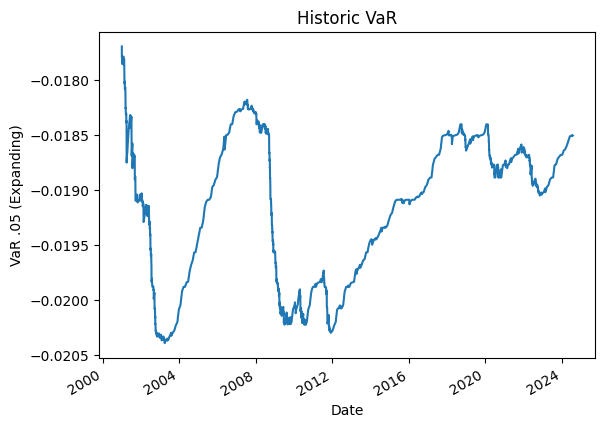

In [14]:
def get_hit_percent(cvars, returns):
    return sum(returns < cvars) / sum(~cvars.isna())

df_e_returns["var_05_expanding"] = window_util(df_e_returns["SPY"], 
                                                func=lambda x: x.quantile(0.05), 
                                                window_type='expanding',
                                                start_date = "20010102",
                                                shift=1
                                                )

exceed = get_hit_percent(df_e_returns["var_05_expanding"], df_e_returns["SPY"])
print(f'Exceed Percent - 5% VaR Expanding: {exceed:.2%}')

# plot
df_e_returns["var_05_expanding"].plot(title = 'Historic VaR', 
                                           ylabel = 'VaR .05 (Expanding)', 
                                           xlabel = 'Date')
plt.show()

* What drawbacks do you see in this historic VaR?

This approach uses historical data so its very sensative to realized events and noise. It also gives equal weights to every timestamp. This wouldn't account for different economic regimes.
Finally VaR is not subadditive.

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

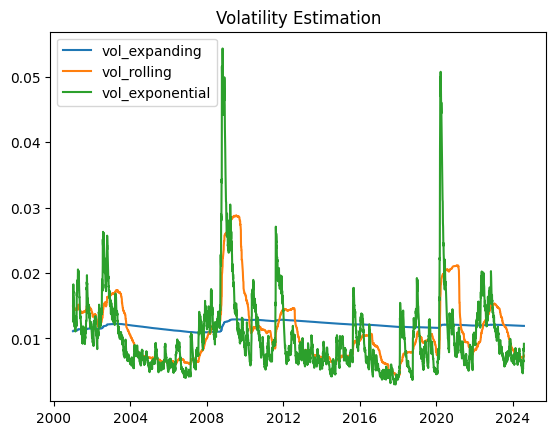

In [15]:
df_vol = pd.DataFrame()

df_vol["vol_expanding"] = window_util(df_e_returns["SPY"], 
                                      func=lambda x: np.sqrt(sum(x**2)/len(x)), 
                                      window_type='expanding',
                                      start_date = "20010102",
                                      shift=1
                                      )
df_vol["vol_rolling"] = window_util(df_e_returns["SPY"], 
                                      func=lambda x: np.sqrt(sum(x**2)/len(x)), 
                                      window_type='rolling',
                                      start_date = "20010102",
                                      window_size=252,
                                      shift=1
                                      )
# exponential
theta = .94
for i, date in enumerate(df_vol.index):
    if date == pd.to_datetime("20010102"):
        df_vol.loc[date, "vol_exponential"] = .20 / np.sqrt(252)
    elif date > pd.to_datetime("20010102"):
        prev_return = df_e_returns.iloc[i-1]["SPY"]**2
        prev_exp = df_vol.iloc[i-1]["vol_exponential"]**2
        df_vol.loc[date, "vol_exponential"] = np.sqrt(theta * prev_exp + (1-theta) * prev_return)


plt.figure()
for c in df_vol.columns:
    plt.plot(df_vol[c], label=c)
plt.legend()
plt.title("Volatility Estimation")
plt.show()

Exceed Percent - 5% VaR Expanding: 4.61%
Exceed Percent - 5% VaR Rolling: 5.28%
Exceed Percent - 5% VaR Exponential: 5.99%


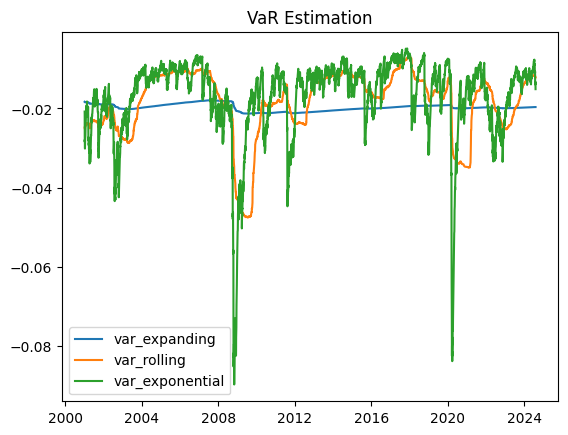

In [16]:
df_var = pd.DataFrame()
df_var["var_expanding"] = -1.65 * df_vol["vol_expanding"]
df_var["var_rolling"] = -1.65 * df_vol["vol_rolling"]
df_var["var_exponential"] = -1.65 * df_vol["vol_exponential"]


# Hit percents
exceed = get_hit_percent(df_var["var_expanding"], df_e_returns["SPY"])
print(f'Exceed Percent - 5% VaR Expanding: {exceed:.2%}')
exceed = get_hit_percent(df_var["var_rolling"], df_e_returns["SPY"])
print(f'Exceed Percent - 5% VaR Rolling: {exceed:.2%}')
exceed = get_hit_percent(df_var["var_exponential"], df_e_returns["SPY"])
print(f'Exceed Percent - 5% VaR Exponential: {exceed:.2%}')

plt.figure()
for c in df_var.columns:
    plt.plot(df_var[c], label=c)
plt.legend()
plt.title("VaR Estimation")
plt.show()

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

Using an expanding window and assuming normal gives similar results to the empirical approach. Rolling and exponential gives lower VaR values and is a lot less smooth. We would also like a 5% VaR such that the returns exceeds the VaR 5% of the time. Our expanding and rolling give a good estimate with the returns exceeding 4.61% and 5.28 respectfully. Exponential underestimates the VaR and gives a exceed percent of 6%.

***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

Exceed Percent - 5% cVaR Expaning: 2.51%
Exceed Percent - 5% cVaR Rolling: 3.31%
Exceed Percent - 5% cVaR Exponential: 3.19%


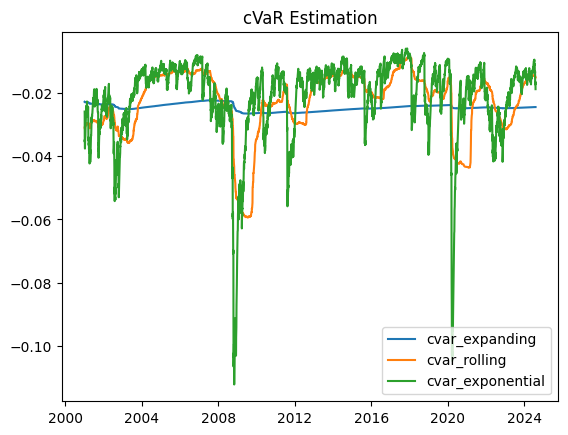

In [17]:
percent_cvar = 0.05
cvar_multiplier = -1 * stats.norm.pdf(stats.norm.ppf(percent_cvar)) / percent_cvar


df_cvar = pd.DataFrame()
df_cvar["cvar_expanding"] = cvar_multiplier * df_vol["vol_expanding"]
df_cvar["cvar_rolling"] = cvar_multiplier * df_vol["vol_rolling"]
df_cvar["cvar_exponential"] = cvar_multiplier * df_vol["vol_exponential"]

# Hit percents
exceed = get_hit_percent(df_cvar["cvar_expanding"], df_e_returns["SPY"])
print(f'Exceed Percent - 5% cVaR Expaning: {exceed:.2%}')
exceed = get_hit_percent(df_cvar["cvar_rolling"], df_e_returns["SPY"])
print(f'Exceed Percent - 5% cVaR Rolling: {exceed:.2%}')
exceed = get_hit_percent(df_cvar["cvar_exponential"], df_e_returns["SPY"])
print(f'Exceed Percent - 5% cVaR Exponential: {exceed:.2%}')

plt.figure()
for c in df_cvar.columns:
    plt.plot(df_cvar[c], label=c)
plt.legend()
plt.title("cVaR Estimation")
plt.show()

Using cVaR instead of VaR gives similar results in each method. Since we just changed the multiplier, the shapes of the curves are the same. For the cVaRs, they are more negative.

***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.